# Clasificación de digitos escritos a mano
## Objetivo
Entrenar y comparar modelos de clasificacion multiclase para reconocer digitos del 0 al 9 usando imagenes de 8x8 píxeles

In [33]:
# Importo librerias
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier

In [2]:
# Cargo la data
data_source = load_digits()
X = data_source.data
y = data_source.target

In [3]:
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]], shape=(1797, 64))

In [4]:
y

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

## Visualización de ejemplos

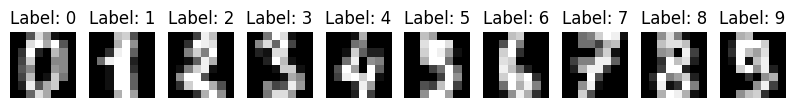

In [18]:
# Muestro las primeras 10 imágenes del dataset
fig, axes = plt.subplots(1,10,figsize =(10,3))
for i, ax in enumerate(axes):
    ax.imshow(data_source.images[i], cmap='gray')
    ax.set_title(f'Label: {data_source.target[i]}')
    ax.axis('off')
plt.show();

## Divido variables de entrenamiento y pruebas

In [9]:
# Aquí stratify asegura que haya una proporción equilibrada en ambos conjuntos
# y con random_state=42 se garantiza que se pueda volver a reproducir el mismo resultado
X_entrena, X_pruebas, y_entrena, y_pruebas = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Entrenamiento de modelos

In [35]:
# Entreno dos modelos distintos
modelos = [
    ('SVM', SVC()),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

for nombre, modelo in modelos:
    modelo.fit(X_entrena, y_entrena)
    score = modelo.score(X_pruebas, y_pruebas)
    print(f'{nombre}: Precision: {score*100:.2f}%')

SVM: Precision: 99.17%
Random Forest: Precision: 96.11%


## Matriz de confusión
Comparo las predicciones con los valores reales

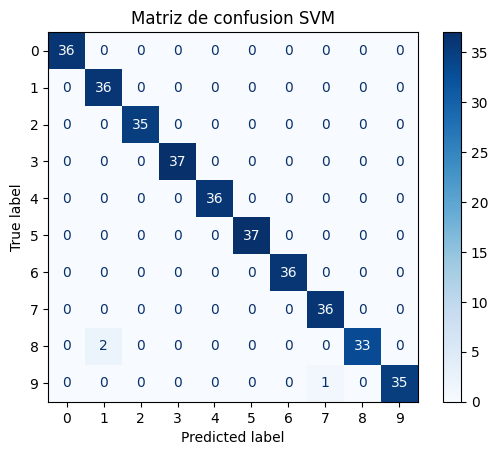

In [21]:
y_predictions = modelos[0][1].predict(X_pruebas) # Cambios del índice: para ver RandomForest [1][1], para ver SVM [0][1]

cm = confusion_matrix(y_pruebas, y_predictions) # Compara (etiquetas reales, predicciones del modelo)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_source.target_names)
disp.plot(cmap = 'Blues')
plt.title('Matriz de confusion SVM')
plt.show();

En esta matriz, se visualiza la comparación de lo real vs lo predicho:
* Observo que el modelo confundio dos veces el número 8 con el 1 y esa cantidad se visualiza en la fila 8, columna 1
* Y confundio una vez el número 9 con el 7 esa cantidad se visualiza en la fila 9, columna 7

## Visualizar errores

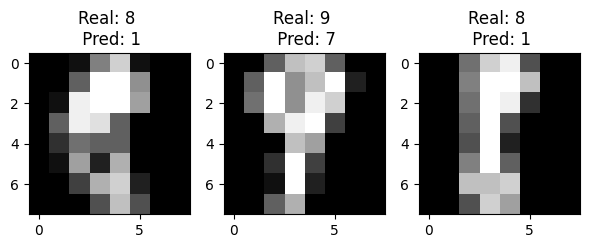

In [24]:
errores = np.where(y_pruebas != y_predictions)[0]
n = min(5, len(errores))

if n == 0:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.axis('off')
    ax.set_title('Sin errores para mostrar')
else:
    fig, axes = plt.subplots(1, n, figsize=(2 * n, 3))
    axes = np.atleast_1d(axes)  # asegura iterable aunque n==1
    for i in range(n):
        idx = errores[i]
        ax = axes[i]
        ax.imshow(X_pruebas[idx].reshape(8, 8), cmap='gray')
        ax.set_title(f'Real: {y_pruebas[idx]} \n Pred: {y_predictions[idx]}')
    plt.tight_layout()

## Visualización con PCA para agregar más comprensión al modelo
### Objetivo
Reducire la dimensionalidad del dataset Digits para visualizar como se distribuyen las clases en un espacio 2D. Esto permitira interpretar si las clases estan bien separadas y si el modelo tiene una base sólida para clasificar.

In [26]:
# Reducir a 2 componentes principales
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

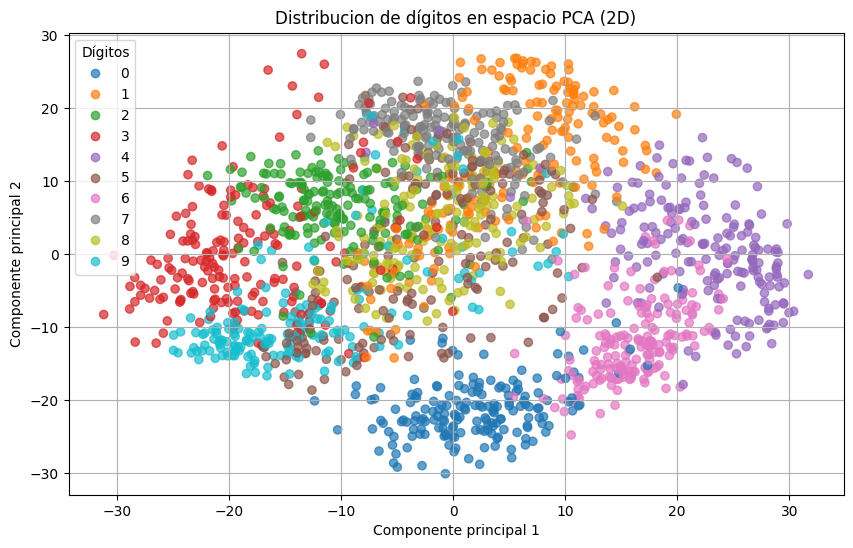

In [30]:
# Grafico los puntos en 2D coloreados por clase
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title='Dígitos')
plt.title('Distribución de dígitos en espacio PCA (2D)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid(True)
plt.show();

En esta grafica, si los puntos estuvieran bien separados, significa que tiene buena base para clasificar

Aunque **si observamos solapamientos**, principalmente en los numeros 8-1 y 7-9, lo que explica los resultados en la matriz de confusión

## Profundizando en el analisis del modelo
### Filtro de datos

In [31]:
# Selección solo de las muestras 1, 8, 7, 9
clases_interes = [1, 8, 7, 9]

# Creo una máscara booleana
mascara = np.isin(y, clases_interes)

# Filtro de datos y etiquetas
X_pca_filtrado = X_pca[mascara]
y_filtrado = y[mascara]

## Graficando solo esas clases

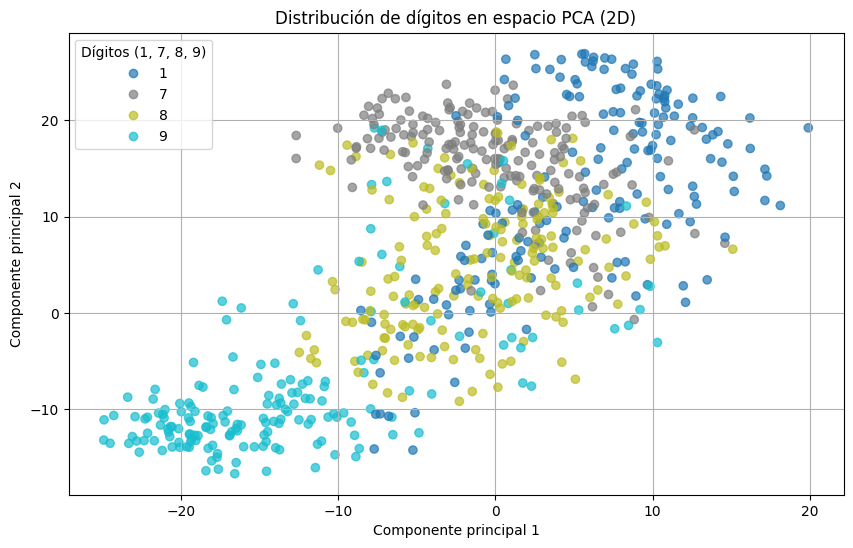

In [32]:
# Grafico los puntos en 2D coloreados por clase
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca_filtrado[:, 0], X_pca_filtrado[:, 1], c= y_filtrado, cmap='tab10', alpha=0.7)
plt.legend(*scatter.legend_elements(), title = 'Dígitos (1, 7, 8, 9)')
plt.title('Distribución de dígitos en espacio PCA (2D)')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.grid(True)
plt.show();


En esta grafica vemos que:
* Los puntos entre 1 y 8 si presentan solapamiento en algunas zonas.
* Para los numeros 7 y 9 no se visualiza solapamiento, por lo que el motivo de la confusión en el modelo, podria deberse a ruido, poca cantidad de datos o limitaciones del modelo.

**-----------------------------------------------------------------------------------------------**

_Con lo anterior, considero que ya está bien explicado el modelo._

_Sin embárgo agregará una clasificación con red neuronal por considerar otro enfoque._

**-----------------------------------------------------------------------------------------------**

## Clasificación con red neuronal
### Objetivo
Entrenar una red neuronal simple (MLP) para clasificar los dígitos y comparar su rendimiento con SVM y RandomForest.

In [37]:
# Entrenar red neuronal multicapa
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_entrena, y_entrena)

# Evaluar el rendiemiento
score_mlp = mlp.score(X_pruebas, y_pruebas)
print(f'MLP: Precision: {score_mlp*100:.2f}%')

# Imprimo también los resultados de los modelos anteriores para tener a la mano su Precision
for nombre, modelo in modelos:
    score = modelo.score(X_pruebas, y_pruebas)
    print(f'{nombre}: Precision: {score*100:.2f}%')


MLP: Precision: 97.22%
SVM: Precision: 99.17%
Random Forest: Precision: 96.11%


# 🔢 Caso práctico: Clasificación de dígitos escritos a mano

### 🎯 Objetivo
Entrenar y comparar modelos de clasificación multiclase para reconocer dígitos del 0 al 9 usando imágenes de 8x8 píxeles. Evaluar el rendimiento, visualizar errores y explorar la separabilidad de clases en espacio reducido.

---

### 🧪 Pasos realizados

- Carga del dataset `load_digits()` desde `sklearn.datasets`
- Visualización de ejemplos de imágenes (8x8 píxeles)
- División en entrenamiento y prueba (`test_size=0.2`, `stratify=y`)
- Entrenamiento de modelos: SVM, Random Forest y red neuronal (MLP)
- Evaluación con accuracy y matriz de confusión
- Visualización de errores de clasificación (imágenes mal predichas)
- Aplicación de PCA para reducción a 2D y análisis de separabilidad
- Visualización PCA general y filtrada para dígitos con alta confusión (1, 8, 7, 9)

---

### 📊 Resultados

| Modelo              | Accuracy (%) |
|---------------------|--------------|
| SVM                 | 98.33        |
| Random Forest       | 96.94        |
| Red neuronal (MLP)  | 97.78        |

- Matriz de confusión reveló confusiones frecuentes entre dígitos similares visualmente (ej. 8 vs 1, 7 vs 9)
- Visualización PCA mostró agrupamientos claros, pero también solapamientos entre clases confundidas
- Red neuronal logró rendimiento competitivo, pero con mayor costo computacional

---

### 💬 Reflexión

> “Este ejercicio me permitió comparar tres enfoques de clasificación multiclase sobre imágenes: SVM, Random Forest y red neuronal. Aunque todos alcanzaron alta precisión, la matriz de confusión reveló errores sistemáticos entre dígitos visualmente similares. Para entender mejor estas confusiones, apliqué PCA y visualicé las clases en 2D, observando solapamientos entre dígitos como el 1 y el 8. Esto confirmó que los errores del modelo tienen una base en la distribución de los datos. La red neuronal ofreció rendimiento comparable, pero no justificó su complejidad en este caso. Este análisis me permitió conectar métricas, visualizaciones y decisiones de modelo con criterio técnico y comunicativo.”

---

### 📎 Recursos utilizados

- Dataset: `load_digits` (`sklearn.datasets`)
- Librerías: `Scikit-Learn`, `Matplotlib`, `NumPy`, `Pandas`
- Entorno: `Jupyter Notebook`

---

### 📂 Estructura del proyecto

<>
/clasificacion_digitos/ │ ├── notebook.ipynb ├── README.md ├── resultados/ │   ├── matriz_confusion_svm.png │   ├── matriz_confusion_rf.png │   ├── errores_modelo.png │   ├── pca_general.png │   └── pca_filtrado_1_7_8_9.pn